# Library usage

## Simple Parallel Calculation

Once you have everything installed and running you can run your first real 
calculation. The first step is to import the modules to your 
program (the examples here use VASP calculator)

In [1]:
from ase.spacegroup import crystal
import ase.units as units
import numpy
import matplotlib.pyplot as plt

from parcalc import ClusterVasp, ParCalculate

from elastic import get_pressure, BMEOS, get_strain
from elastic import get_elementary_deformations, scan_volumes
from elastic import get_BM_EOS, get_elastic_tensor

next we need to create our example MgO crystal:

In [2]:
a = 4.194
cryst = crystal(['Mg', 'O'], 
                [(0, 0, 0), (0.5, 0.5, 0.5)], 
                spacegroup=225,
                cellpar=[a, a, a, 90, 90, 90])

We need a calculator for our job, here we use VASP and ClusterVasp defined 
in the parcalc module. You can probably replace this calculator by any other ASE
calculator but this was not tested yet. Thus let us define the calculator:

In [3]:
# Create the calculator running on one, eight-core node.
# This is specific to the setup on my cluster.
# You have to adapt this part to your environment
calc = ClusterVasp(nodes=1, ppn=8)

# Assign the calculator to the crystal
cryst.set_calculator(calc)

# Set the calculation parameters
calc.set(prec = 'Accurate', xc = 'PBE', lreal = False,  
            nsw=30, ediff=1e-8, ibrion=2, kpts=[3,3,3])

# Set the calculation mode first.
# Full structure optimization in this case.
# Not all calculators have this type of internal minimizer!
calc.set(isif=3)

Finally, run our first calculation. Obtain relaxed structure and 
residual pressure after optimization:

In [4]:
print("Residual pressure: %.3f bar" % (
        get_pressure(cryst.get_stress())))

Residual pressure: 0.000 bar


If this returns proper pressure (close to zero) we can use the obtained 
structure for further calculations. For example we can scan the volume axis to
obtain points for equation of state fitting. This will demonstrate the 
ability to run several calculations in parallel - if you have a cluster of
machines at your disposal this will speed up the calculation considerably.

Workers started: 5


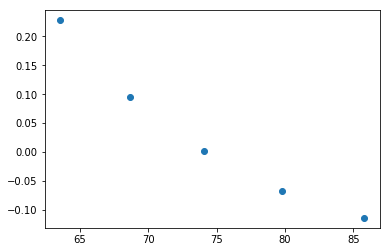

In [5]:
# Lets extract optimized lattice constant.
# MgO is cubic so a is a first diagonal element of lattice matrix
a=cryst.get_cell()[0,0]

# Clean up the directory
calc.clean()

systems=[]
# Iterate over lattice constant in the +/-5% range
for av in numpy.linspace(a*0.95,a*1.05,5):
    systems.append(crystal(['Mg', 'O'], [(0, 0, 0), (0.5, 0.5, 0.5)], 
                    spacegroup=225, cellpar=[av, av, av, 90, 90, 90]))

# Define the template calculator for this run
# We can use the calc from above. It is only used as a template.
# Just change the params to fix the cell volume
calc.set(isif=2)

# Run the calculation for all systems in sys in parallel
# The result will be returned as list of systems res
res=ParCalculate(systems,calc)

# Collect the results
v=[]
p=[]
for s in res :
    v.append(s.get_volume())
    p.append(get_pressure(s.get_stress()))

# Plot the result (you need matplotlib for this
plt.plot(v,p,'o')
plt.show()

Birch-Murnaghan Equation of State
---------------------------------

Let us now use the tools provided by the modules to calculate equation 
of state for the crystal and verify it by plotting the data points against
fitted EOS curve. The EOS used by the module is a well established 
Birch-Murnaghan formula (P - pressure, V - volume, B - parameters):

$$
   P(V)= \frac{B_0}{B'_0}\left[
   \left({\frac{V}{V_0}}\right)^{-B'_0} - 1
   \right]
$$

Now we repeat the setup and optimization procedure from the example 1 above 
but using a new Crystal class (see above we skip this part for brevity). 
Then comes a new part (IDOF - Internal Degrees of Freedom):

Workers started: 5
V0=74.233 A^3 ; B0=168.19 GPa ; B0'=4.270 ; a0=4.20275 A


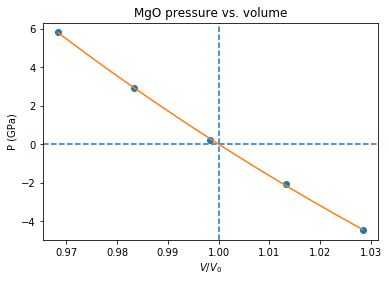

In [6]:
# Switch to cell shape+IDOF optimizer
calc.set(isif=4)

# Calculate few volumes and fit B-M EOS to the result
# Use +/-3% volume deformation and 5 data points
deform=scan_volumes(cryst, n=5,lo=0.97,hi=1.03)

# Run the calculations - here with Cluster VASP
res=ParCalculate(deform,calc)

# Post-process the results
fit=get_BM_EOS(cryst, systems=res)

# Get the P(V) data points just calculated
pv=numpy.array(cryst.pv)

# Sort data on the first column (V)
pv=pv[pv[:, 0].argsort()]

# Print just fitted parameters
print("V0=%.3f A^3 ; B0=%.2f GPa ; B0'=%.3f ; a0=%.5f A" % ( 
        fit[0], fit[1]/units.GPa, fit[2], pow(fit[0],1./3)))

v0=fit[0]

# B-M EOS for plotting
fitfunc = lambda p, x: numpy.array([BMEOS(xv,p[0],p[1],p[2]) for xv in x])

# Ranges - the ordering in pv is not guarateed at all!
# In fact it may be purely random.
x=numpy.array([min(pv[:,0]),max(pv[:,0])])
y=numpy.array([min(pv[:,1]),max(pv[:,1])])


# Plot the P(V) curves and points for the crystal
# Plot the points
plt.plot(pv[:,0]/v0,pv[:,1]/units.GPa,'o')

# Mark the center P=0 V=V0
plt.axvline(1,ls='--')
plt.axhline(0,ls='--')

# Plot the fitted B-M EOS through the points
xa=numpy.linspace(x[0],x[-1],20)
plt.plot(xa/v0,fitfunc(fit,xa)/units.GPa,'-')
plt.title('MgO pressure vs. volume')
plt.xlabel('$V/V_0$')
plt.ylabel('P (GPa)')
plt.show()

If you set up everything correctly you should obtain fitted parameters printed 
out in the output close to:

$$
   V_0 = 73.75 \text{ A}^3 \quad
   B_0 = 170 \text{ GPa}  \quad
   B'_0 = 4.3  \quad
   a_0 = 4.1936 \text{ A}
$$

Calculation of the elastic tensor
---------------------------------

Finally let us calculate an elastic tensor for the same simple cubic crystal -
magnesium oxide (MgO). For this we need to create the crystal and optimize its 
structure (see :ref:`parcalc` above). Once we have an optimized structure we can
switch the calculator to internal degrees of freedom optimization (IDOF) and
calculate the elastic tensor:

In [7]:
# Switch to IDOF optimizer
calc.set(isif=2)

# Create elementary deformations
systems = get_elementary_deformations(cryst, n=5, d=0.33)

# Run the stress calculations on deformed cells
res = ParCalculate(systems, calc)

# Elastic tensor by internal routine
Cij, Bij = get_elastic_tensor(cryst, systems=res)
print("Cij (GPa):", Cij/units.GPa)

Workers started: 10
Cij (GPa): [ 338.46921273  103.64272667  152.2150523 ]


To make sure we are getting the correct answer let us make the calculation 
for $C_{11}, C_{12}$ by hand. We will deform the cell along a (x) axis
by +/-0.2% and fit the $3^{rd}$ order polynomial to the stress-strain 
data. The linear component of the fit is the element of the elastic tensor:

In [8]:
from elastic.elastic import get_cart_deformed_cell

# Create 10 deformation points on the a axis
systems = []
for d in numpy.linspace(-0.2,0.2,10):
    systems.append(get_cart_deformed_cell(cryst, axis=0, size=d))

# Calculate the systems and collect the stress tensor for each system
r = ParCalculate(systems, cryst.calc)
ss=[]
for s in r:
    ss.append([get_strain(s, cryst), s.get_stress()])

ss=numpy.array(ss)
lo=min(ss[:,0,0])
hi=max(ss[:,0,0])
mi=(lo+hi)/2
wi=(hi-lo)/2
xa=numpy.linspace(mi-1.1*wi,mi+1.1*wi, 50)

Workers started: 10


C11 = 325.005 GPa, C12 = 102.441 GPa => K= 176.629 GPa


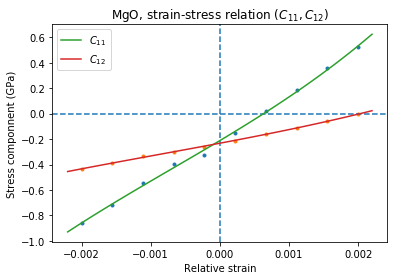

In [9]:
# Make a plot
plt.plot(ss[:,0,0],ss[:,1,0]/units.GPa,'.')
plt.plot(ss[:,0,0],ss[:,1,1]/units.GPa,'.')

plt.axvline(0,ls='--')
plt.axhline(0,ls='--')

# Now fit the polynomials to the data to get elastic constants
# C11 component
f=numpy.polyfit(ss[:,0,0],ss[:,1,0],3)
c11=f[-2]/units.GPa

# Plot the fitted function
plt.plot(xa,numpy.polyval(f,xa)/units.GPa,'-', label='$C_{11}$')

# C12 component
f=numpy.polyfit(ss[:,0,0],ss[:,1,1],3)
c12=f[-2]/units.GPa

# Plot the fitted function
plt.plot(xa,numpy.polyval(f,xa)/units.GPa,'-', label='$C_{12}$')
plt.xlabel('Relative strain')
plt.ylabel('Stress componnent (GPa)')
plt.title('MgO, strain-stress relation ($C_{11}, C_{12}$)')
plt.legend(loc='best')
# Here are the results. They should agree with the results
# of the internal routine.
print('C11 = %.3f GPa, C12 = %.3f GPa => K= %.3f GPa' % (
        c11, c12, (c11+2*c12)/3))

plt.show()

If you set up everything correctly you should obtain fitted parameters printed 
out in the output close to:

    Cij (GPa): [ 340   100   180]

With the following result of fitting:

    C11 = 325 GPa, C12 = 100 GPa => K= 180 GPa
    
The actual numbers depend on the details of the calculations setup but should be fairly close to the above results.